#### Getting ready
In the first three chunks, I install packages and import modules. I also load the raw data and pick out the parts I need analyse.

In [1]:
# install the needed packages
%pip install spacy
%pip install gensim
%pip install pyLDAvis
%matplotlib inline

# after executing this chunk, I restart the kernel

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 30.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 664.3 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.6/181.6 kB 4.4 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 20.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 913.3/913.3 kB 4.4 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.7/124.7 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 492.9/492.9 kB 6.4 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.9/45.9 kB 953.7 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 31.6 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.4/26.4 MB 24.

In [1]:
#after restarting the kernel, I import the needed modules
import matplotlib.pyplot as plt
import datetime
import gensim
import numpy as np
import spacy
import pandas as pd 

!python3 -m spacy download da_core_news_sm
nlp = spacy.load("da_core_news_sm") #danish spacy 

import pyLDAvis.gensim
import os, re, operator, warnings
warnings.filterwarnings('ignore') # we don't need to pay attention to warnings right now

from collections import Counter

from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel
from gensim.corpora import Dictionary

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 25.7 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('da_core_news_sm')


In [19]:
import sys # check which version of python I'm using
print(sys.version)

3.10.6 | packaged by conda-forge | (main, Aug 22 2022, 20:36:39) [GCC 10.4.0]


#### Import and check out raw data

After getting an overview of the raw data, I create a new dataframe from the raw data only including tweet ID, text of the tweet, timestamp and reference data (whether the tweet was original, retweeted or quoted).

As only the 'text' column is called the same as in the original dataframe, the other three columns start out empty, but that's okay, because I just want a dataframe with columns the same length as in raw_data.

Then I fill out the other three columns, "ID", "time" and "reference" with the data from the columns "author_id", "created_at" and "referenced_tweets" from raw_data.

I also order the raw tweets after occurrence, to look at the most common (as en retweeted the most times) tweets, which will come in handy in the process of cleaning up the text. For example, the word "flire" (a nonsense word in Danish) kept coming up in the topic modeling, which I realized was an incorrect lemmatization of "flirte" (to flirt).

In [2]:
raw_data = pd.read_json('../data/normstormerne.ndjson', lines=True) # load raw data

raw_data # view data
print(list(raw_data.keys())) # overview of the columns in the data

df = pd.DataFrame(raw_data, columns=['ID', 'text', 'time', 'reference']) # create new dataframe with the columns I need

# fill out empty columns
df['ID'] = raw_data['author_id']
df['time'] = raw_data['created_at']
df['reference'] = raw_data['referenced_tweets']

# check out the data
#print(df[0:20]) # view the 20 first rows of the new dataset
#print(df['text'][0:20]) # check out the tweet texts specifically

common_raw_tweets = Counter(raw_data['text']).most_common() # get a look at the most common tweets in the dataset
#print(common_raw_tweets)

['possibly_sensitive', 'in_reply_to_user_id', 'entities', 'author_id', 'lang', 'id', 'edit_history_tweet_ids', 'text', 'created_at', 'reply_settings', 'public_metrics', 'referenced_tweets', 'conversation_id', 'errors', 'includes', 'attachments', 'geo']


#### Plot the timeline

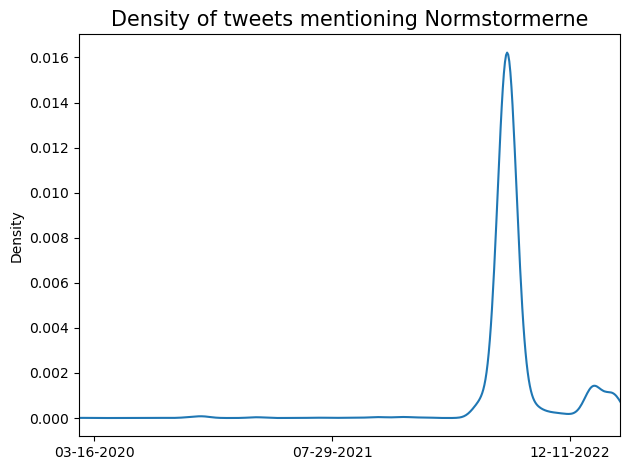

In [3]:
# Density plot

#print(df['time'].info) #look at the data
#print((df['time'][0]))

df_time = pd.DataFrame(df, columns=['ID', 'time', 'ordinal', 'tweets_pr_day'])
df_time = df_time.iloc[::-1] # as the data shows the most recent tweets first, I flip the dataframe, so I can plot it in chronological order

df_time['ordinal'] = [x.toordinal() for x in df_time.time] #create a column "ordinal" with values extracted from the ordinal timestamp column

df_time.to_csv("df_time.csv")

#print(df_time[0:10])
#print(type(df_time['ordinal'][0]))

ax = df_time['ordinal'].plot(kind='kde') #kde = kernel density estimation

x_ticks = ax.get_xticks() #I'm still not quite sure what the x_ticks do, and I couldn't find good information on it online
ax.set_xticks(x_ticks)

# to zoom in on the media storm, I put xmin to 738305 (the date 2022-05-30), just before the mediastorm really starts
x_lim = (min(df_time['ordinal']), max(df_time['ordinal']))
ax.set_xlim(x_lim)

# to get the dates as labels for the x axis
xlabels = [datetime.datetime.fromordinal(int(x)) 
               .strftime('%m-%d-%Y') for x in x_ticks]

ax.set_xticklabels(xlabels) #set x axis labels
plt.title("Density of tweets mentioning Normstormerne", size = 15) #title

# set the figure size and layout
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True

plt.savefig('fig1.png') #save it for the paper
plt.show() #show here

<AxesSubplot: title={'center': 'Number of tweets per day mentioning Normstormerne'}, xlabel='Date', ylabel='Number of tweets'>

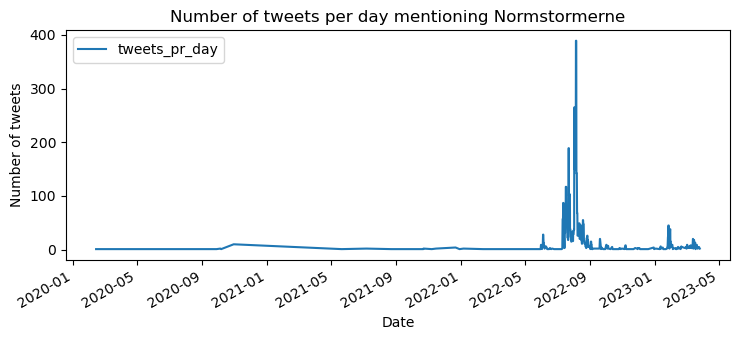

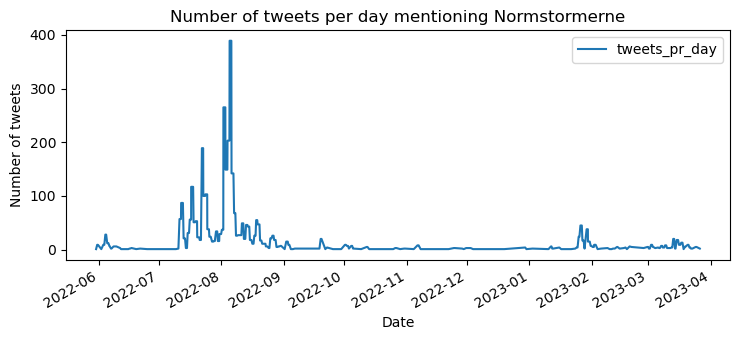

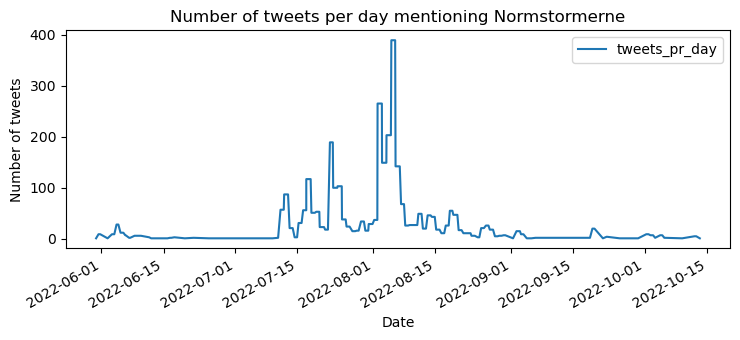

In [4]:
# get the days with most tweets
count_tweet_days = Counter(df_time['ordinal']).most_common()

#check out the data
print(len(count_tweet_days))
print(count_tweet_days[0:5])

for t in range(len(df_time['tweets_pr_day'])):
    for c in range(len(count_tweet_days)):
        if df_time['ordinal'][t] == count_tweet_days[c][0]:
            df_time['tweets_pr_day'][t] = count_tweet_days[c][1]

# save this dataframe to make it easier to inspect
df_time.to_csv("df_time.csv")

# make a shorter dataframe, that starts just before the media storm is about to begin (May 30, 2022)
df_time_short = df_time[43:3526]
df_time_shorter = df_time[43:3095] # I can also zoom in even more on the period with the most tweets, but this doesn't actually tell us anything new

#print(df_time)
#print(df_time_short)

#plot the whole time series as well as the plot starting on May 30 2022, just before the media storm started (the last tweet before this date was February 11 2022)
df_time.plot(x='time', y='tweets_pr_day', xlabel='Date', ylabel='Number of tweets', title="Number of tweets per day mentioning Normstormerne")
df_time_short.plot(x='time', y='tweets_pr_day', xlabel='Date', ylabel='Number of tweets', title="Number of tweets per day mentioning Normstormerne")
df_time_shorter.plot(x='time', y='tweets_pr_day', xlabel='Date', ylabel='Number of tweets', title="Number of tweets per day mentioning Normstormerne")

#you can see from plot 3 that twitter really exploded around August 2, where a representative from Normstormerne went on the TV program "Deadline"

In [5]:
# look at some timeline numbers
print(len(df_time_shorter)) # 3052 tweets are shown on the last plot
print(738401-738347) # number of days with the most tweets (54) , from July 11-September 3, 2022
print((3383-500)/3525) # 81,78 % of tweets were created during these 54 days

3052
54
0.8178723404255319


#### Clean up the references

In [5]:
# clean up the reference column

for t in range(len(df['reference'])):
    if type(df['reference'][t]) == list: # if the tweet is an original tweet, the cell is just blank in the dataframe, so first I have to distinguish between whether the index consists of a list (which replies, retweets and quotes do) or not
        df['reference'][t] = list(df['reference'][t][0].values())[0]
    else:
        continue # if t is not a list (in the cases when the cell is empty because it's an original tweet), skip to the next iteration

#print(type(raw_data['text']))
count_references = Counter(df['reference']).most_common() # get a look at the most common tweets in the dataset
print(count_references) #prints [('replied_to', 1845), ('retweeted', 1096), (nan, 460), ('quoted', 124)]

[('replied_to', 1845), ('retweeted', 1096), (nan, 460), ('quoted', 124)]


#### Look at top tweeters

In [6]:
common_tweeters = Counter(df['ID']).most_common() # get a look at the most common tweets in the dataset

# I wanted to look (very exploratory) on how many tweets different tweeters made, so I created a new column for this
df['tweets_pr_ID'] = df['ID']

for t in range(len(df['tweets_pr_ID'])):
    for c in range(len(common_tweeters)):
        if df['tweets_pr_ID'][t] == common_tweeters[c][0]:
            df['tweets_pr_ID'][t] = common_tweeters[c][1]
            
print(f'''number of tweeters: {len(common_tweeters)}''')
print(f'''number of tweets per tweeters: {3525/len(common_tweeters)}''')
common_tweeters[0:10] # how many tweets did the top 10 tweeters tweet

837
0.0124822695035461
SD of tweets per tweeter: 6.503902660115628e+17
<class 'numpy.float64'>


In [7]:
# i also add a column to the dataframe displaying tweets per day (makes it easy to explore when the media storm was on it's highest)

df['tweets_pr_day'] = df['ID'] # first I just add another column with the same length as the others (copy the ID column just for simplicity)

for t in range(len(df['ID'])):
    for i in range(len(df_time['time'])):
        if df['time'][t] == df_time['time'][i]:
            df['tweets_pr_day'][t] = df_time['tweets_pr_day'][i]

In [8]:
# This chunk gives us the mean and standard deviation of tweets per ID
tweet_pr_ID_list = []

for i in range(len(common_tweeters)):
    tweet_pr_ID_list.append(common_tweeters[i][1])

#print(tweet_pr_ID_list[0:20])
print(np.std(tweet_pr_ID_list)) #get the standard deviation
print(np.average(tweet_pr_ID_list)) #get the mean

6.705188246904665
3.1642728904847397


In [9]:
# This chunk gives us the mean and standard deviation of tweets per day

count_tweet_days = Counter(df_time['ordinal']).most_common() #most busy tweet days

tweet_pr_day_list = [] # empty list

for i in range(len(count_tweet_days)):
    tweet_pr_day_list.append(count_tweet_days[i][1])

# subtract the smallest ordinal timestamp in the dataset (equivalent to the first day of data collection) from highest timestamp, and subtract the number of days with tweets (the length of the count_tweet_days list)
days_without_tweets = ((max(df_time['ordinal'])-min(df_time['ordinal']))-(len(count_tweet_days))) # there were 933 in the period of collection with no tweets

zero_list = [0]*(days_without_tweets) # make 933 0's
#print(zero_list)
tweet_pr_day_list = tweet_pr_day_list + zero_list # add the 933 0's to the tweet_pr_day_list
#print(tweet_pr_day_list[0:300])

# now we can get the average n of tweets per day and the standard deviation
# - of course we didn't have to do all this to get the average, but we do for the SD
print(np.average(tweet_pr_day_list)) # Mean = 3.100263852242744. 
print(np.std(tweet_pr_day_list)) # SD = 19.28644809096694

3.100263852242744
19.28644809096694


In [10]:
# correlation between tweets per day and number of tweets per tweeter (I didn't mention this in the paper because of space limitations)
rho = np.corrcoef(df['tweets_pr_day'], df['tweets_pr_ID'])
print(rho) # r = -0.01290965, meaning no correlation at all (very close to zero)

df.to_csv("almost_cleaned_tweets.csv") # so I don't have to run all of this again every time I return to the code

-0.012909654682830462


#### Cleaning up the text data

The next chunk cleans up the text column of the dataframe. The for loop below loops through the text column and does the following things:
- Removes mentions - by substituting any string that starts with "@" with nothing (""). NB: This procedure leaves extra spaces that I remove at the end of the loop)
- Removes links that start with https - again, substititutes a string that starts with "https" with ""
- Removes "RT" from the beginning of retweeted tweets - same procedure as the two steps above
- Removes punctuation. NB: this also gets rid of emojis - which could of course also be analysed if the goal was sentiment analysis
- Makes everything lowercase
- Streamlines words that have multiple spellings in the dataset, e.g. "lgbt+" "lgbt" and "lgbtq" where the spelling variants don't usually reflect different intentions of the author (there just isn't a consensus on which acronym to use)
- Corrects some obvious misspellings, such as "indvander" (changed to "indvandrer") and "identitetespolitisk" (changed to "identitetspolitisk")
- Takes care of a few bigrams, such as the political party "radikale venstre", where "radikal" by itself might be misunderstood and "venstre" in itself could refer to the party, the direction or a political leaning to the left (where venstre is right wing and radikale venstre is central)
- Collects words with very similar meanings such as "folkeskolelærer", "skolelærer" and "lærer" and collects "københavn" and its abbreviation "kbh"

##### More indepth notes on the second round of normalization that didn't make it into the paper itself:

During the second round of normalization, I chose to streamline some word types, i.e., rename different types into a single one. This was done for words with multiple spellings in the dataset, for types that I judged as synonyms for each-other, and in cases where conjugations of the same word were not caught by the lemmatizer. For example, all spelling variants of lgbt* were renamed lgbt, as versions such as “LGBT+” or “LGBTQ” usually reflect a lack of consensus on the acronym, rather than different intentions of the author. Similarly, the abbreviation kbh was changed to københavn. 

In some cases, I chose to combine nouns and verbs that in terms of content relay more or less the same information – such as indoktrinering* and indoktrinere*, that were renamed simply indoktrin. In the case of politik*, politisk*, politiser*, all were changed to politik – because although the different words carry slightly different meanings, it is more meaningful to the topic modeling to bundle up all references to politics in one.

It was observed that the text had instances of both lærer*, skolelærer*, and folkeskolelærer*, all of which refer to (primary school) teachers. These three types were renamed simply lærer. Using the same principle, folkeskole* was changed to just skole. I also chose to rename all word types starting with undervis* to just undervis. This included the types undervise, underviser as well as undervisning and was done mostly because the types, although different word classes, refer to the general concept of teaching. Furthermore, because underviser can refer both to a person and a present verb, and undervisning can refer to teaching in general, but also a specific lesson, the nuances in meaning would have to be assessed with a part-of-speech tagging. I decided that this differentiating was not necessary for the current analysis, although one could definitely argue that it is bad practice to rename only specific types in a corpus but not follow a rigid set of principles for renaming similar types throughout the body of text. For example, I did not collect lære and lærer, even though the latter can both refer to a teacher but also present form of “to learn”. 

Another choice of bundling up words with similar meaning was to collect all mentions of NS’s teaching material into the word materiale. This included undervisningsmateriale, uvm (the abbreviation), *manual* (with asterisk both in front and back of the type as undervisningsmanual also occurred), and finally drejebog. 

A few obvious misspellings were corrected, such as indvander which was changed to indvandrer and identitetespolitisk, changed to identitetspolitisk. A few compound nouns were also corrected. For example, køns- og identitetspolitik was changed to kønspolitik og identitetspolitik, and køns identitet was renamed kønsidentitet. Two bigrams were collected to one string, namely pink washing, renamed pinkwashing, and radikale venstre which was renamed rv. In the case of radikale venstre (a political party), I made sure that venstre had to be followed by a space, so as not to catch den radikale venstrefløj or the like. 

Finally, the type kønss occurred 33 times in the data, and by further inspection, it turned out to originate from a tweet retweeted 32 times that referred to juridisk kønss. My interpretation was that kønss most likely was a shortening of kønsskifte, as juridisk kønsskifte, i.e., legal gender reassignment, is a fairly common bigram and currently a hot topic within the gender discourse in Denmark (at least anecdotally from my own experience). 


In [2]:
# final text normalization 
df = pd.read_csv('almost_cleaned_tweets.csv') #import data, so I don't have to run everything above again

for t in range(len(df['text'])):
    
    # remove strings that we are not interested in
    df['text'][t] = re.sub("@\S*", "", df['text'][t]) # remove mentions
    df['text'][t] = re.sub("https\S*", "", df['text'][t]) # remove links
    df['text'][t] = re.sub("RT", "", df['text'][t]) # remove "RT"
    df['text'][t] = re.sub("[0-9]", "", df['text'][t]) # remove numbers

    # after removing "RT" which has to be upper case, we make everything else lower case
    df['text'][t] = df['text'][t].lower() # Make everything lowercase

    # take care of a few compound nouns
    df['text'][t] = re.sub("køns- og identitetspolitik\S*", "kønspolitik og identitetspolitik", df['text'][t]) # change versions "køns-" where the intention is a compound noun
    df['text'][t] = re.sub("køns- og seksualpolitik\S*", "kønspolitik og seksualpolitik", df['text'][t]) # change versions "køns-" where the intention is a compound noun
    df['text'][t] = re.sub("køns- og normkritik\S*", "kønskritik og normkritik", df['text'][t]) # change versions "køns-" where the intention is a compound noun
    
     # after taking care of the compound nouns and hashtags, I remove punctuation
    df['text'][t] = re.sub(r"[^\w\s]", "", df['text'][t]) # remove punctuation
    
    # further text cleanup: 
    # group together words that have multiple spellings/versions with the same meaning
    df['text'][t] = re.sub("normst\S*", "normstorm", df['text'][t]) # make all versions of normst* into just normstorm (I have noticed "normst", "normsto", "normstorm", "normstorme", "normstormer" and "normstormerne" in the dataset alongside 
    df['text'][t] = re.sub("lgb\S*", "lgbt", df['text'][t]) # make all versions of lgbt* (including lgb) into just lgbt (someone might intentially write lgb to exclude trans people, but it seems more meaningful to group it with the other versions of the abbreviation)
    df['text'][t] = re.sub("indoktrin\S*", "indoktrin", df['text'][t]) # make all versions of indoktrin* into just indoktrin (OBS: there is one version of "indoktrineringsmateriale" which will become indoktrin and thus not counted as "materiale"
    df['text'][t] = re.sub("ideolog\S*", "ideologi", df['text'][t]) # collect different observed versions of ideologi (also seen as ideologer and ideologisk)
    df['text'][t] = re.sub("politisk\S*|politik\S*|politiser\S*", "politik", df['text'][t]) # collect politisk, politik, politiker, politisere and other similar words that refer to politics

    # sort out some of the most common words with "køn" in it
    df['text'][t] = re.sub("kønss$", "kønsskifte", df['text'][t]) # change kønss to kønsskifte - one tweet has been retweetet 32 times that mentions "jurisk kønss", which very most likely refers to "juridsk kønsskifte"
    df['text'][t] = re.sub("køns$", "køn", df['text'][t]) # change køns to køn (the lemmatizer doesn't do this)
    df['text'][t] = re.sub("kønsidenti\S*|køns identi\S*", "kønsidentitet", df['text'][t]) # collect different observed spellings of kønsidentitet
    df['text'][t] = re.sub("kønsideolog\S*", "kønsideologi", df['text'][t]) # collect different versions of kønsideologi (also seen as kønsideologer and kønsideologisk)
    
    # collect "kbhs", "københavns" and "københavnsk" to "kbh"
    df['text'][t] = re.sub("københavn\S*", "kbh", df['text'][t]) 
    df['text'][t] = re.sub("kbh\S*", "kbh", df['text'][t]) # make all versions of normstorm* into just normstorm

    # collect all the words that refer to Normstormerne's teaching material under the word "materiale"
    df['text'][t] = re.sub("uvm\S*", "materiale", df['text'][t]) # change the abbreviation "uvm" ("undervisningsmateriale") to "materiale"
    df['text'][t] = re.sub("\S*material\S*", "materiale", df['text'][t]) # change any compound noun that includes "materiale" to "materiale" (e.g. "instruktionsmateriale")
    df['text'][t] = re.sub("\S*manual\S*", "materiale", df['text'][t]) # "manual" has also been used to refer to the material
    df['text'][t] = re.sub("drejebog\S*", "materiale", df['text'][t]) # "drejebog" has also been used to refer to the material
    
    # collect the words for teaching and teacher
    df['text'][t] = re.sub("undervis\S*", "undervis", df['text'][t]) # collect versions of "undervis*" into "undervis", including undervisning and underviser - although if "underviser" refers to a teacher and not the present "teaches" then it might be misleading to collect them, as I don't collect "lærer" and "lære" for example
    df['text'][t] = re.sub("^skolelærer|folkeskolelærer", "lærer", df['text'][t]) # collect "skolelærer" and "folkeskolelærer" to just "lærer"
    df['text'][t] = re.sub("folkeskole", "skole", df['text'][t]) # change "folkeskole" to just "skole"

    # collect a few bigrams
    df['text'][t] = re.sub("radikale venstre ", "rv ", df['text'][t]) # remove the space from the bigram "radikale venstre" (the bigram has to end with a space, so we dont get e.g. "radikale venstrefløj" (the radical leftwing)
    df['text'][t] = re.sub("pink washing", "pinkwashing", df['text'][t]) # collect "pink washing" to "pinkwashing" (the latter occurs a few times already)

    # correct a few misspellings
    df['text'][t] = re.sub("indvander", "indvandrer", df['text'][t]) # change "indvander" til "indvandrer"
    df['text'][t] = re.sub("identitetespolitisk", "identitetspolitisk", df['text'][t]) # "identitetspolitisk" is miss-spelled "identitetespolitisk" at some point
    df['text'][t] = re.sub("radikalevenster", "rv", df['text'][t]) # correct this typo of "radikale venstre"
    
    # last touch
    df['text'][t] = " ".join(df['text'][t].split()) # Remove extra spaces (in the original tweets and left over from removing unwanted strings)


In [23]:
df.to_csv("cleaned_tweets.csv") # so I don't have to run all of this again every time I return to the code

In [ ]:
df = pd.read_csv('cleaned_tweets.csv') # import data again when I proceed to the next steps of analysis

#### Stop words, bag of words and corpus

I create a stopword list from a Danish one that I found here: https://gist.github.com/berteltorp/0cf8a0c7afea7f25ed754f24cfc2467b#file-stopord-txt

After a few iterations of topic modeling and inspecting results, I add a bunch of stop words that I have noticed weren't in the original stop word list. 

I also add normstorm (which includes all versions of normstorm*) and it's abbreviation "ns" to the stop list because I know it will be present in all the tweets and will therefore skew the search - but it might be helpful for other kinds of analysi thus I only add it to the stop word list, instead of removing it from the dataset entirely

In [3]:
# read the stop word list
with open('stopord.txt') as f:
    lines = f.read() 

stopwords = lines.split() # split the words at line break

for w in range(len(stopwords)):
    stopwords[w] = re.sub(r"[^\w\s]", "", stopwords[w]) # remove punctuation

#print(stopwords)
#print(type(stopwords))

# add more stop words
# there are a few tweets that use two, three or four line breaks, so I add these as stop words
more_stopwords = ['\n\n'] +['\n\n\n'] + ['\n\n\n\n'] + ['tja'] + ['haha'] + ['hahaha'] + ['inkl'] + ['mfl'] + ['dvs'] + ['arh'] + ['aah'] + ['mm'] + ['nb'] + ['jvf'] + ['ka'] + ['cirka'] + ['ogeller'] + ['ml'] + ['kl'] + ['mht'] + ['ps'] + ['f'] + ['h'] + ['s'] + ['p'] + ['r'] + ['evt'] + ['næh'] + ['no'] + ['nix'] + ['an'] + ['ik'] + ['pr'] + ['org'] + ['oh'] + ['åh'] + ['mf'] + ['ve'] + ['pa'] + ['ang'] + ['vh'] + ['iflg'] + ['bliv'] + ['ska'] + ['nan']

# I also add "normstorm" and it's abbreviation "ns" to it's own small stop word list that I can choose to add to the big one or not - for this analysis, I'm adding them
ns_stopwords = ['normstorm'] + ['ns'] 

# combine the stop word lists
stopwords = stopwords + ns_stopwords + more_stopwords

# check that all the words in the stop word list are actually stop words according to Spacy's is_stop function
for stopword in stopwords:
    #print(stopword)
    lexeme = nlp.vocab[stopword]
    #print(lexeme)
    lexeme.is_stop = True # I'm not sure if this actually works though, because it accept all words I try to feed it

# get a look at the stop words in alphabetical order
#print(sorted(more_stopwords))
#print(sorted(stopwords))

In [4]:
text_str = '' #make an empty string

for i in range(len(df['text'])):
    text_str = text_str + str(df['text'][i]) + '''\n''' #add every tweet in the text column to the text string, devided by a line shift
    
doc = nlp(text_str) # tokenize the text with spacy, thus making it into a "Doc" object

#print(df['text'][0]) #see what the first word is in the first tweet, so I can check that the tokenization worked - the first word is "er"
assert doc[0].text == "er" # the first token is "er", so everything seems in order 

#check out the doc
#print(doc)
#type(doc)

# make three empty lists: one for all of the tweets, one for each individual tweet and one bag of words where order doesn't matter
tweet, all_tweets, bag_of_words = [], [], [] 

# go through every tweet and sort out the stop words, before adding the tweet to the text
for w in doc:
    if w.text != '\n' and not w.is_stop and not w.is_punct and not w.like_num: # if w is not a stop word or a number (including written out numbers)
        tweet.append(w.lemma_) # then add the lematized version of the word to the tweet list
        bag_of_words.append(w.lemma_) # also append the word to the bag of words
    if w.text == '\n': # if w is a new line then we're onto our next tweet
        all_tweets.append(tweet) # and in that case, add the tweet to the all_tweets list
        tweet = [] # and clean the tweet list, so we can begin filling it with the next tweet

dictionary = Dictionary(all_tweets) # make the all_tweets list into a dictionary
corpus = [dictionary.doc2bow(text) for text in all_tweets] #make the dictionary into a corpus that we can do topic modeling on

In [73]:
# check out the new objects I just made
print(dictionary)
print(corpus[0:20])
print(bag_of_words[0:11])

Dictionary<6860 unique tokens: ['barn', 'damebad', 'drag', 'hadtal', 'id']...>
[[(0, 2), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1)], [(16, 1), (17, 1), (18, 1)], [(19, 1)], [(20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1)], [(20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1)], [(20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1)], [(30, 1), (31, 1)], [(24, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1)], [(24, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1)], [(41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1)], [(0, 2), (47, 1), (48, 1), (49, 1), (50, 1), (51, 2), (52, 1), (53, 1), (54, 2), (55, 1), (56, 1), (57, 1)], [(0, 1), (14, 1), (58, 1), (59, 1), (60, 1), (61, 2), (62, 1), (63, 1), (64, 1), (65, 1), (66, 1), (67, 1), (68, 1), (69, 3), (70, 1), (71, 1), (72, 1), (73, 1)], [(0, 1),

In [5]:
# check out the most common words in the bag of words (the corpus is also in "bag of words" style, but vectorised, so this is an easy way to get the most common words
common_words = Counter(bag_of_words).most_common() # get a look at the most common words used in the tweets

common_words[0:30]
#print(len(common_words)) # there are 6867 types in the bag of words, after preprocessing

#print(common_words[0:50])#[6850:6866] # I look both at some of the most common and most uncommon words
#print(sorted(common_words)) # I also look the words sorted alphabetically and can see that the lemmatizer has given some words capital letters, maybe words that it doesn't understand because they are English or abbreviations so it assumes that they are names


[('barn', 627),
 ('undervis', 558),
 ('skole', 403),
 ('materiale', 291),
 ('politik', 269),
 ('lgbt', 218),
 ('lærer', 206),
 ('mene', 203),
 ('kbh', 202),
 ('dkpol', 183),
 ('køn', 171),
 ('lære', 151),
 ('dansk', 149),
 ('ideologi', 141),
 ('forælder', 139),
 ('hvid', 132),
 ('bruge', 129),
 ('indoktrin', 128),
 ('læse', 126),
 ('kritik', 121),
 ('norm', 119),
 ('tale', 118),
 ('folk', 115),
 ('stå', 113),
 ('organisation', 113),
 ('sidste', 110),
 ('skrive', 109),
 ('tro', 109),
 ('klasse', 109),
 ('debat', 107)]

#### Topic modeling

We're now ready to topic model! I use two different models, LDA and HDP. Because HDP decides itself how many topics the text has (and it always decides on 20 every time I run it), I choose to run LDA with 2-20 topic

In [11]:
# prepare a function that plots coherence values of topic models
def evaluate_bar_graph(coherences, indices):
    """
    Function to plot bar graph.
    Coherences: list of coherence values
    Indices: Indices to be used to mark bars.
    """
    assert len(coherences) == len(indices) # check that the length of coherences equals the length of the indices
    n = len(coherences) # get the length of each list of coherence values
    x = np.arange(n) # on the x-axis we want the coherence values, arranged to be evenly spaced
    plt.bar(x, coherences, width=0.2, tick_label=indices, align='center') # plot the coherence measure as bars, with "indices" as tick labels
    plt.xlabel('Topic models')
    plt.ylabel('Coherence value')

In [7]:
# Hierarchical Dirichlet Process (HDP) model
hdpmodel = HdpModel(corpus=corpus, id2word=dictionary) # run the model

# get the probability scores of each model (????)
hdptopics = [[word for word, prob in topic] for topicid, topic in hdpmodel.show_topics(formatted=False)]

# get coherence value
hdp_coherence = CoherenceModel(topics=hdptopics[:10], texts=all_tweets, dictionary=dictionary, window_size=10).get_coherence()

[(0,
  '0.001*undervis + 0.001*væk + 0.001*trække + 0.001*fejlfri + 0.001*barn + 0.001*spies + 0.001*kønsrelatere + 0.001*lærergruppe + 0.001*shows + 0.001*konkre + 0.001*vest + 0.001*fantastisk + 0.001*metaforik + 0.001*forandre + 0.001*lgbt + 0.001*handle + 0.001*debat + 0.001*kampagn + 0.001*femina + 0.001*strukturel'),
 (1,
  '0.002*uanset + 0.001*fornuft + 0.001*sidestykke + 0.001*citat + 0.001*sund + 0.001*oplevels + 0.001*sekundær + 0.001*lukke + 0.001*regle + 0.001*ideologi + 0.001*erfare + 0.001*mail + 0.001*barn + 0.001*debatindlæg + 0.001*kritik + 0.001*betydelig + 0.001*transfobisk + 0.001*undervis + 0.001*strategi + 0.001*hemmeligholde'),
 (2,
  '0.002*afde + 0.001*muslimsk + 0.001*gide + 0.001*vanvittig + 0.001*pligt + 0.001*transmand + 0.001*fædreland + 0.001*planke + 0.001*frabad + 0.001*genopfinde + 0.001*krigsførsel + 0.001*urimelig + 0.001*ihvertfald + 0.001*virkelighedsfornægtelse + 0.001*angsskabende + 0.001*publicere + 0.001*forsvar + 0.001*embedsapparatet + 0.001

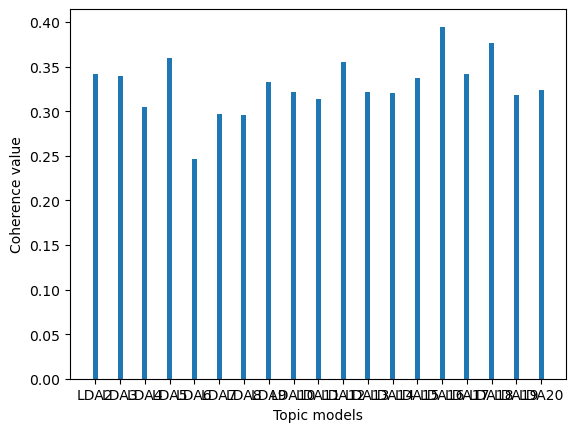

In [55]:
# Latent Dirichlet Allocation (LDA) model - try out models with 2-20 topics
# this could definitely have been a loop...
ldamodel2 = LdaModel(corpus=corpus, num_topics=2, id2word=dictionary)
ldamodel3 = LdaModel(corpus=corpus, num_topics=3, id2word=dictionary)
ldamodel4 = LdaModel(corpus=corpus, num_topics=4, id2word=dictionary)
ldamodel5 = LdaModel(corpus=corpus, num_topics=5, id2word=dictionary)
ldamodel6 = LdaModel(corpus=corpus, num_topics=6, id2word=dictionary)
ldamodel7 = LdaModel(corpus=corpus, num_topics=7, id2word=dictionary)
ldamodel8 = LdaModel(corpus=corpus, num_topics=8, id2word=dictionary)
ldamodel9 = LdaModel(corpus=corpus, num_topics=9, id2word=dictionary)
ldamodel10 = LdaModel(corpus=corpus, num_topics=10, id2word=dictionary)
ldamodel11 = LdaModel(corpus=corpus, num_topics=11, id2word=dictionary)
ldamodel12 = LdaModel(corpus=corpus, num_topics=12, id2word=dictionary)
ldamodel13 = LdaModel(corpus=corpus, num_topics=13, id2word=dictionary)
ldamodel14 = LdaModel(corpus=corpus, num_topics=14, id2word=dictionary)
ldamodel15 = LdaModel(corpus=corpus, num_topics=15, id2word=dictionary)
ldamodel16 = LdaModel(corpus=corpus, num_topics=16, id2word=dictionary)
ldamodel17 = LdaModel(corpus=corpus, num_topics=17, id2word=dictionary)
ldamodel18 = LdaModel(corpus=corpus, num_topics=18, id2word=dictionary)
ldamodel19 = LdaModel(corpus=corpus, num_topics=19, id2word=dictionary)
ldamodel20 = LdaModel(corpus=corpus, num_topics=20, id2word=dictionary)

# get the probability scores of each model (????)
# again, this could definitely have been a loop...
ldatopics2 = [[word for word, prob in topic] for topicid, topic in ldamodel2.show_topics(formatted=False)]
ldatopics3 = [[word for word, prob in topic] for topicid, topic in ldamodel3.show_topics(formatted=False)]
ldatopics4 = [[word for word, prob in topic] for topicid, topic in ldamodel4.show_topics(formatted=False)]
ldatopics5 = [[word for word, prob in topic] for topicid, topic in ldamodel5.show_topics(formatted=False)]
ldatopics6 = [[word for word, prob in topic] for topicid, topic in ldamodel6.show_topics(formatted=False)]
ldatopics7 = [[word for word, prob in topic] for topicid, topic in ldamodel7.show_topics(formatted=False)]
ldatopics8 = [[word for word, prob in topic] for topicid, topic in ldamodel8.show_topics(formatted=False)]
ldatopics9 = [[word for word, prob in topic] for topicid, topic in ldamodel9.show_topics(formatted=False)]
ldatopics10 = [[word for word, prob in topic] for topicid, topic in ldamodel10.show_topics(formatted=False)]
ldatopics11 = [[word for word, prob in topic] for topicid, topic in ldamodel11.show_topics(formatted=False)]
ldatopics12 = [[word for word, prob in topic] for topicid, topic in ldamodel12.show_topics(formatted=False)]
ldatopics13 = [[word for word, prob in topic] for topicid, topic in ldamodel13.show_topics(formatted=False)]
ldatopics14 = [[word for word, prob in topic] for topicid, topic in ldamodel14.show_topics(formatted=False)]
ldatopics15 = [[word for word, prob in topic] for topicid, topic in ldamodel15.show_topics(formatted=False)]
ldatopics16 = [[word for word, prob in topic] for topicid, topic in ldamodel16.show_topics(formatted=False)]
ldatopics17 = [[word for word, prob in topic] for topicid, topic in ldamodel17.show_topics(formatted=False)]
ldatopics18 = [[word for word, prob in topic] for topicid, topic in ldamodel18.show_topics(formatted=False)]
ldatopics19 = [[word for word, prob in topic] for topicid, topic in ldamodel19.show_topics(formatted=False)]
ldatopics20 = [[word for word, prob in topic] for topicid, topic in ldamodel20.show_topics(formatted=False)]

# get the coherence measure of each model 
lda_coherence2 = CoherenceModel(topics=ldatopics2[:10], texts=all_tweets, dictionary=dictionary, window_size=10).get_coherence()# added the [:10] because it wasn't there before - not quite sure what difference it does
lda_coherence3 = CoherenceModel(topics=ldatopics3[:10], texts=all_tweets, dictionary=dictionary, window_size=10).get_coherence()
lda_coherence4 = CoherenceModel(topics=ldatopics4[:10], texts=all_tweets, dictionary=dictionary, window_size=10).get_coherence()# added the [:10] because it wasn't there before - not quite sure what difference it does
lda_coherence5 = CoherenceModel(topics=ldatopics5[:10], texts=all_tweets, dictionary=dictionary, window_size=10).get_coherence()# added the [:10] because it wasn't there before - not quite sure what difference it does
lda_coherence6 = CoherenceModel(topics=ldatopics6[:10], texts=all_tweets, dictionary=dictionary, window_size=10).get_coherence()# added the [:10] because it wasn't there before - not quite sure what difference it does
lda_coherence7 = CoherenceModel(topics=ldatopics7[:10], texts=all_tweets, dictionary=dictionary, window_size=10).get_coherence()# added the [:10] because it wasn't there before - not quite sure what difference it does
lda_coherence8 = CoherenceModel(topics=ldatopics8[:10], texts=all_tweets, dictionary=dictionary, window_size=10).get_coherence()# added the [:10] because it wasn't there before - not quite sure what difference it does
lda_coherence9 = CoherenceModel(topics=ldatopics9[:10], texts=all_tweets, dictionary=dictionary, window_size=10).get_coherence()# added the [:10] because it wasn't there before - not quite sure what difference it does
lda_coherence10 = CoherenceModel(topics=ldatopics10[:10], texts=all_tweets, dictionary=dictionary, window_size=10).get_coherence()# added the [:10] because it wasn't there before - not quite sure what difference it does
lda_coherence11 = CoherenceModel(topics=ldatopics11[:10], texts=all_tweets, dictionary=dictionary, window_size=10).get_coherence()# added the [:10] because it wasn't there before - not quite sure what difference it does
lda_coherence12 = CoherenceModel(topics=ldatopics12[:10], texts=all_tweets, dictionary=dictionary, window_size=10).get_coherence()# added the [:10] because it wasn't there before - not quite sure what difference it does
lda_coherence13 = CoherenceModel(topics=ldatopics13[:10], texts=all_tweets, dictionary=dictionary, window_size=10).get_coherence()# added the [:10] because it wasn't there before - not quite sure what difference it does
lda_coherence14 = CoherenceModel(topics=ldatopics14[:10], texts=all_tweets, dictionary=dictionary, window_size=10).get_coherence()# added the [:10] because it wasn't there before - not quite sure what difference it does
lda_coherence15 = CoherenceModel(topics=ldatopics15[:10], texts=all_tweets, dictionary=dictionary, window_size=10).get_coherence()# added the [:10] because it wasn't there before - not quite sure what difference it does
lda_coherence16 = CoherenceModel(topics=ldatopics16[:10], texts=all_tweets, dictionary=dictionary, window_size=10).get_coherence()# added the [:10] because it wasn't there before - not quite sure what difference it does
lda_coherence17 = CoherenceModel(topics=ldatopics17[:10], texts=all_tweets, dictionary=dictionary, window_size=10).get_coherence()# added the [:10] because it wasn't there before - not quite sure what difference it does
lda_coherence18 = CoherenceModel(topics=ldatopics18[:10], texts=all_tweets, dictionary=dictionary, window_size=10).get_coherence()# added the [:10] because it wasn't there before - not quite sure what difference it does
lda_coherence19 = CoherenceModel(topics=ldatopics19[:10], texts=all_tweets, dictionary=dictionary, window_size=10).get_coherence()# added the [:10] because it wasn't there before - not quite sure what difference it does
lda_coherence20 = CoherenceModel(topics=ldatopics20[:10], texts=all_tweets, dictionary=dictionary, window_size=10).get_coherence()# added the [:10] because it wasn't there before - not quite sure what difference it does


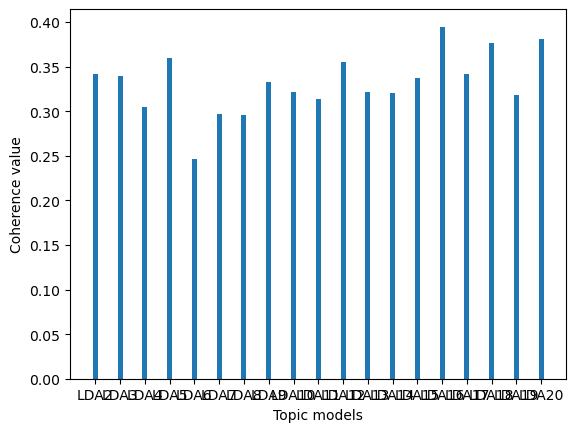

In [62]:
ldamodel20 = LdaModel(corpus=corpus, num_topics=20, id2word=dictionary)
ldatopics20 = [[word for word, prob in topic] for topicid, topic in ldamodel20.show_topics(formatted=False)]
lda_coherence20 = CoherenceModel(topics=ldatopics20[:10], texts=all_tweets, dictionary=dictionary, window_size=10).get_coherence()# added the [:10] because it wasn't there before - not quite sure what difference it does

evaluate_bar_graph([lda_coherence2, lda_coherence3, lda_coherence4, lda_coherence5, lda_coherence6, lda_coherence7, lda_coherence8, lda_coherence9, lda_coherence10, lda_coherence11, lda_coherence12, lda_coherence13, lda_coherence14, lda_coherence15, lda_coherence16, lda_coherence17, lda_coherence18, lda_coherence19, lda_coherence20],
                   ['LDA2', 'LDA3', 'LDA4', 'LDA5', 'LDA6', 'LDA7', 'LDA8', 'LDA9','LDA10', 'LDA11', 'LDA12', 'LDA13', 'LDA14', 'LDA15', 'LDA16', 'LDA17', 'LDA18', 'LDA19', 'LDA20'])

In [57]:
# print and compare some of the best LDA model and the HDP model performances
print(hdp_coherence)
print(lda_coherence16)

0.5802643430653287
0.41510970904373073
0.7074070715854031
0.3946712861346696


In [ ]:
# results: show the topics of the best performing models:
ldamodel16.show_topics(num_topics=16) # Latent Dirichlet Allocation (LDA) model with 16 topics
hdpmodel.show_topics() # Hierarchical Dirichlet Process (HDP) model with 20 topics

In [61]:
# with LDA I can also make a fancy visualization that comes in handy when trying out different numbers of topics (even though LDA seem to be the least coherent model)
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(ldamodel16, corpus, dictionary) 

# by putting the relevance metric to 0.0, I can zoom in on words that are relatively unique to a given topic, even if they might not occur that many times

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.080409  0.028329       1        1  11.246344
6      0.071773 -0.004595       2        1   9.053346
13     0.063637  0.011557       3        1   8.335474
14     0.097571 -0.002895       4        1   7.853798
1      0.071547 -0.066054       5        1   7.543241
8     -0.004196 -0.124112       6        1   6.770769
0      0.055908  0.188839       7        1   6.151452
7     -0.071162  0.037490       8        1   5.372352
15    -0.044303 -0.001950       9        1   5.345581
3      0.023527 -0.063781      10        1   5.345385
5      0.010059 -0.003167      11        1   5.345015
2     -0.008860 -0.080409      12        1   5.154155
9     -0.154595  0.042870      13        1   4.659176
11    -0.109508 -0.037093      14        1   4.292399
10    -0.036647  0.070412      15        1   3.907821
12    -0.045160  0.004559      16        1   3.623692, topic_info=            Term        Freq       Total Category  logprob  loglift
2287   udtalelse   56.000000   56.000000  Default  30.0000  30.0000
1047  samarbejde   61.000000   61.000000  Default  29.0000  29.0000
565       sidste  123.000000  123.000000  Default  28.0000  28.0000
1692     tegning   50.000000   50.000000  Default  27.0000  27.0000
3754      udgive   48.000000   48.000000  Default  26.0000  26.0000
...          ...         ...         ...      ...      ...      ...
0           barn   10.451327  532.682912  Topic16  -4.7870  -0.6135
324      overfor    6.145495   32.209868  Topic16  -5.3180   1.6611
303      problem    7.172252  101.990805  Topic16  -5.1635   0.6630
716          par    6.733204   72.201432  Topic16  -5.2267   0.9453
1033        slet    6.134832   36.887100  Topic16  -5.3198   1.5238

[1053 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
545       2  0.017634    Danmark
545       3  0.017634    Danmark
545       4  0.158705    Danmark
545       5  0.035268    Danmark
545       6  0.493750    Danmark
...     ...       ...        ...
182      14  0.036447      ønske
182      16  0.054671      ønske
4542     14  0.843456  østeuropa
2207     12  0.106144      øvrig
2207     16  0.849155      øvrig

[3069 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 7, 14, 15, 2, 9, 1, 8, 16, 4, 6, 3, 10, 12, 11, 13])

In [ ]:
# some extra things I could have looked at

# collocations

# bag of words - 20 most common words - maybe word cloud

# make negative bi-grams for loaded words, e.g. "identitetspolitik" or "højreradikal", to see if some people are saying that is ISN'T those things

# compare different LDA models with varied amounts of topics